# Titanic Prediction

The aim is to build a classification model to predict if a passenger would survive the titanic disaster or not. The dataset has features pertaining to each passenger which include details like gender, the class they travelled by, fare paid etc. The entire code is split into 5 sections which include loading data, feature engineering, exploratory data analysis, model building and testing.

## Section - 1: Loading Libraries and Data

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

from statistics import mean, stdev
from math import sqrt

import pickle

In [8]:
### Loading the training and testing datasets
train = pd.read_csv('input/train.csv',sep = ',')
test = pd.read_csv('input/test.csv',sep = ',')
print(train.head(),"Snapshot of training data")

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S   Sn

Survival variable is the response variable and the rest are predictor variables. Out of the predictor variables Passenger ID, Passenger Name and Ticket Number probably do not matter or help in predicting if they would survive or not. We also create a new feature called Members which represents the total number of dependents/members a passenger has.  


In [9]:
total = train['SibSp'] + train['Parch']
train['Members'] = total
total = test['SibSp'] + test['Parch']
test['Members'] = total

train = train[['Survived','Pclass','Sex','Age','Members','Cabin','Embarked','Fare']]
test = test[['Pclass','Sex','Age','Members','Cabin','Embarked','Fare']]

train = train.dropna(subset = ['Embarked'])

### One Hot Encoding the variables
train = pd.concat([train,train.Sex.str.get_dummies()],axis =1)
train = pd.concat([train,train.Embarked.str.get_dummies()],axis =1)
test = pd.concat([test,test.Sex.str.get_dummies()],axis=1)
test = pd.concat([test,test.Embarked.str.get_dummies()],axis =1)

In [10]:
### Checking for NA values in the dataset and dealing with them
print("Number of NA values in each column:")
print(train.isnull().sum(axis = 0))
train_data = train
actual_test_data = test
train_data_only_na_values = train_data[np.isnan(train_data.Age)]
print(train_data_only_na_values.head())

Number of NA values in each column:
Survived      0
Pclass        0
Sex           0
Age         177
Members       0
Cabin       687
Embarked      0
Fare          0
female        0
male          0
C             0
Q             0
S             0
dtype: int64
    Survived  Pclass     Sex  Age  Members Cabin Embarked     Fare  female  \
5          0       3    male  NaN        0   NaN        Q   8.4583       0   
17         1       2    male  NaN        0   NaN        S  13.0000       0   
19         1       3  female  NaN        0   NaN        C   7.2250       1   
26         0       3    male  NaN        0   NaN        C   7.2250       0   
28         1       3  female  NaN        0   NaN        Q   7.8792       1   

    male  C  Q  S  
5      1  0  1  0  
17     1  0  0  1  
19     0  1  0  0  
26     1  1  0  0  
28     0  0  1  0  


Number of people survived:  52
Number of people not survived:  125


Text(0.5, 1.0, 'Count Plot of Survived People according to embarkment point')

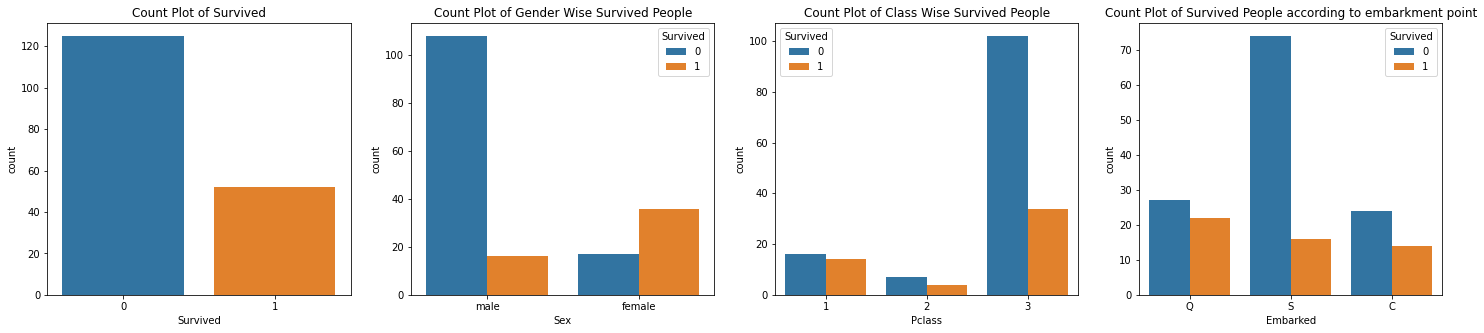

In [29]:
### Plotting details about data pertaining to column where Age is missing
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(25,5))
sns.countplot(x='Survived',data=train_data_only_na_values,ax=ax1)
ax1.set_title('Count Plot of Survived')
print("Number of people survived: ",np.count_nonzero(train_data_only_na_values[['Survived']]))
print("Number of people not survived: ",np.count_nonzero(train_data_only_na_values[['Survived']]==0))

### Looking at the percentage of samples from each class it does not seem like there is a class imbalance

### Plot - 2 is going to show us the distribution of the survival variable with respect to other categorical variables
sns.countplot(x='Sex',hue='Survived',data=train_data_only_na_values,ax=ax2)
ax2.set_title('Count Plot of Gender Wise Survived People')
sns.countplot(x='Pclass',hue='Survived',data=train_data_only_na_values,ax=ax3)
ax3.set_title('Count Plot of Class Wise Survived People')
sns.countplot(x='Embarked',hue='Survived',data=train_data_only_na_values,ax=ax4)
ax4.set_title('Count Plot of Survived People according to embarkment point')

Based on the plots below the values of age seem to be missing at random and do not seem to exhibit any specific pattern. Hence we can proceed forward with imputation techniques
We will be using the KNN imputation technique.

## Section - 2: Splitting Train Data and Missing Data Imputation

In [11]:
scaler = MinMaxScaler()

### Splitting the training dataset itself into another train and test to check which model is the best model
train_data, test_data, y_train, y_test = train_test_split(train_data.loc[:, train_data.columns != 'Survived'],
                                                          train_data[['Survived']],test_size = 0.2,random_state = 1234)
### We will drop the columns Sex and Embarked since they are already one-hot encoded
train_data = train_data.drop(['Sex'],axis=1)
train_data = train_data.drop(['Embarked'],axis=1)

test_data = test_data.drop(['Sex'],axis=1)
test_data = test_data.drop(['Embarked'],axis=1)

### We will drop the Cabin column since more than 60% of the values are missing in the column
train_data = train_data.drop(['Cabin'],axis=1)
print(train_data.head())
test_data = test_data.drop(['Cabin'],axis=1)
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns = train_data.columns)
test_data  = pd.DataFrame(scaler.fit_transform(test_data), columns = test_data.columns)

     Pclass   Age  Members   Fare  female  male  C  Q  S
669       1   NaN        1  52.00       1     0  0  0  1
427       2  19.0        0  26.00       1     0  0  0  1
417       2  18.0        2  13.00       1     0  0  0  1
558       1  39.0        2  79.65       1     0  0  0  1
271       3  25.0        0   0.00       0     1  0  0  1


In [12]:
### KNN Imputation Technique to impute NA values of the Age column
imputer = KNNImputer(n_neighbors=10)
new_train_data = pd.DataFrame(imputer.fit_transform(train_data_scaled),columns = train_data_scaled.columns)
print(new_train_data)

### Imputation of Values in Test Data
test_data = pd.DataFrame(imputer.fit_transform(test_data),columns = test_data.columns)
print(test_data)

     Pclass       Age  Members      Fare  female  male    C    Q    S
0       0.0  0.487107      0.1  0.101497     1.0   0.0  0.0  0.0  1.0
1       0.5  0.263247      0.0  0.050749     1.0   0.0  0.0  0.0  1.0
2       0.5  0.249079      0.2  0.025374     1.0   0.0  0.0  0.0  1.0
3       0.0  0.546614      0.2  0.155466     1.0   0.0  0.0  0.0  1.0
4       1.0  0.348257      0.0  0.000000     0.0   1.0  0.0  0.0  1.0
5       0.0  0.674129      0.1  0.077294     1.0   0.0  1.0  0.0  0.0
6       0.5  0.178237      0.1  0.038061     1.0   0.0  0.0  0.0  1.0
7       1.0  0.334089      0.2  0.032596     1.0   0.0  0.0  0.0  1.0
8       0.5  0.631624      0.0  0.026350     1.0   0.0  0.0  0.0  1.0
9       1.0  0.390762      0.2  0.028107     1.0   0.0  0.0  0.0  1.0
10      0.0  0.617455      0.1  0.113168     1.0   0.0  1.0  0.0  0.0
11      1.0  0.263247      0.0  0.015924     0.0   1.0  0.0  0.0  1.0
12      0.0  0.532445      0.0  0.444099     1.0   0.0  1.0  0.0  0.0
13      1.0  0.37659

# Section - 3: Exploratory Data Analysis (EDA)

In [32]:
### We will inverse our transform to plot for EDA
train_data_final = pd.DataFrame(scaler.inverse_transform(new_train_data),columns = new_train_data.columns)

train_data_final[['Sex']] = 'Male'
idx = train_data_final.index[train_data_final['male']==0.0]
train_data_final.loc[idx,'Sex'] = 'Female'

train_data_final[['Embarked']] = 'C'
idx = train_data_final.index[(train_data_final['C']==0.0) & (train_data_final['Q']==0.0)]
train_data_final.loc[idx,'Embarked'] = 'S'
idx = train_data_final.index[(train_data_final['C']==0.0) & (train_data_final['S']==0.0)]
train_data_final.loc[idx,'Embarked'] = 'Q'
train_data_final[['Survived']] = y_train
train_data_final[['Age']] = np.round(train_data_final[['Age']],0)
train_data_final[['Members']] = train_data[['Members']]
print(train_data_final.head())

   Pclass   Age  Members       Fare  female  male    C    Q    S     Sex  \
0     1.0  39.0      1.0  25.122678     1.0   0.0  0.0  0.0  1.0  Female   
1     2.0  22.0      1.0  12.561339     1.0   0.0  0.0  0.0  1.0  Female   
2     2.0  21.0      0.0   6.280670     1.0   0.0  0.0  0.0  1.0  Female   
3     1.0  44.0      1.0  38.481179     1.0   0.0  0.0  0.0  1.0  Female   
4     3.0  29.0      0.0   0.000000     0.0   1.0  0.0  0.0  1.0    Male   

  Embarked  Survived  
0        S       0.0  
1        S       1.0  
2        S       1.0  
3        S       1.0  
4        S       0.0  


Number of people survived:  367
Number of people not survived:  344


Text(0.5, 1.0, 'Count Plot of Survived People depending on accompanying members')

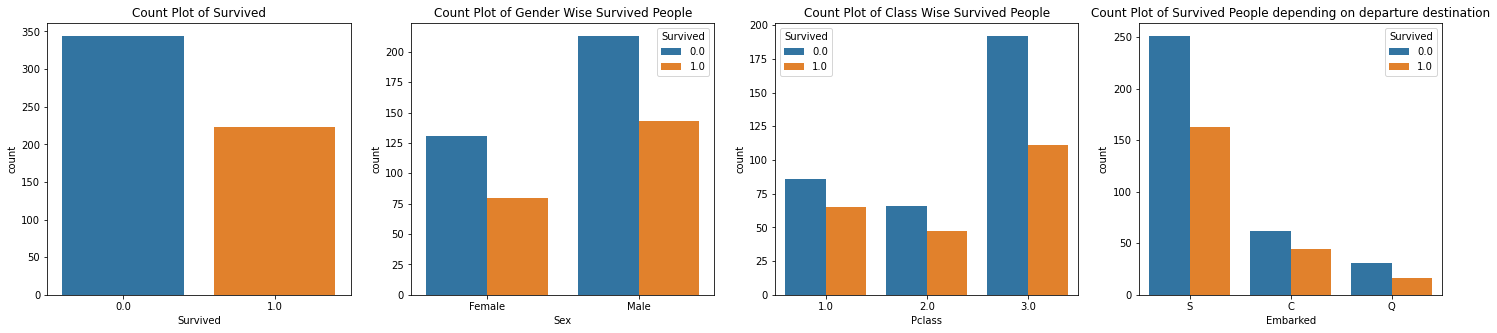

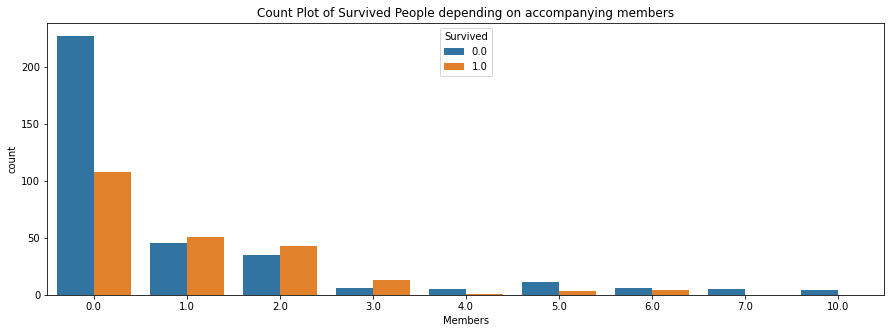

In [33]:
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(25,5))
sns.countplot(x='Survived',data=train_data_final[['Survived']],ax=ax1)
ax1.set_title('Count Plot of Survived')
print("Number of people survived: ",np.count_nonzero(train_data_final[['Survived']]))
print("Number of people not survived: ",np.count_nonzero(train_data_final[['Survived']]==0))

sns.countplot(x='Sex',hue='Survived',data=train_data_final,ax=ax2)
ax2.set_title('Count Plot of Gender Wise Survived People')
sns.countplot(x='Pclass',hue='Survived',data=train_data_final,ax=ax3)
ax3.set_title('Count Plot of Class Wise Survived People')
sns.countplot(x='Embarked',hue='Survived',data=train_data_final,ax=ax4)
ax4.set_title('Count Plot of Survived People depending on departure destination')

plt.figure(figsize=(15,5))
fig1 = sns.countplot(x='Members',hue='Survived',data=train_data_final)
fig1.set_title('Count Plot of Survived People depending on accompanying members')

### Plot - 1 is going to show us the distribution of the survival variable
Looking at the percentage of samples from each class it does not seem like there is a class imbalance. The percentage distribution of the response variable is roughly 60% and 40%, hence we will not need to modify the training data by using any sampling technique

### Plot - 2 is going to show us the distribution of the survival variable with respect to other categorical variables
* The first plot shows us the distribution of people survived according to their gender. Looking at the distribution, it seems a large number of males did not survive the disaster. We can hypothesize that children and spouses of the male members might have boarded the rescue boats before the men and hence a lot of men could have died because they could not get on to the rescue boats at the right time
* The second plot shows us the distribution of survival according to the class travelled. A large number of people travelling by class 3 did not survive the disaster. 
* The third plot shows us the distribution of survival according to the departure destination. A large number of people embarking from destination S seem to have not survived the disaster. It is unusual how source of embarkment affects survival. It is possible a lot of members travelling from destination S were males and hence the survival rate seems to be low.
* The fourth and final plot is about how the number of members affect survival. A large number of people with no sibilings or spouses seemed to have not survived the disaster.


<Figure size 432x288 with 0 Axes>

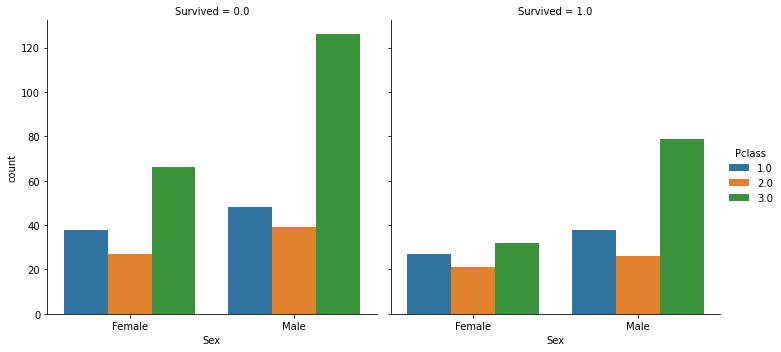

<Figure size 432x288 with 0 Axes>

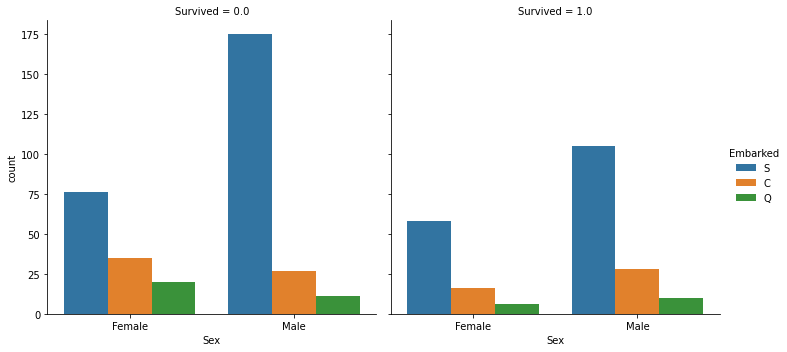

In [34]:
### Plot - 3 is going to include 3 variables 
plt.figure()
sns.catplot(x='Sex',hue='Pclass',col='Survived',kind='count',data=train_data_final)
plt.figure()
sns.catplot(x='Sex',hue='Embarked',col='Survived',kind='count',data=train_data_final)

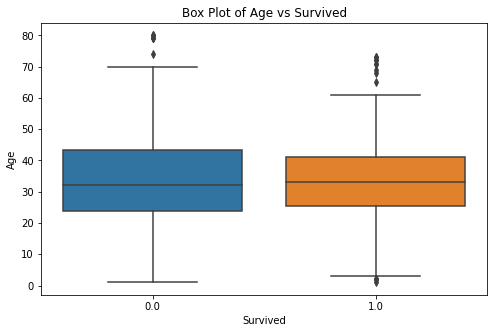

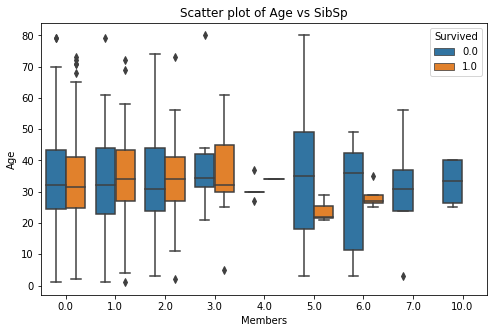

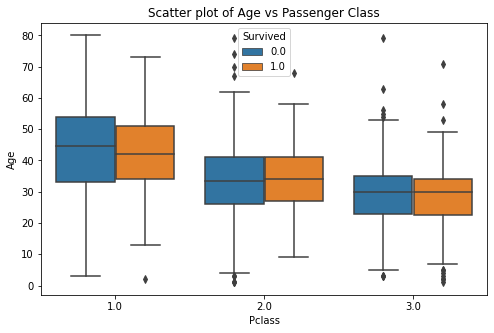

<Figure size 576x360 with 0 Axes>

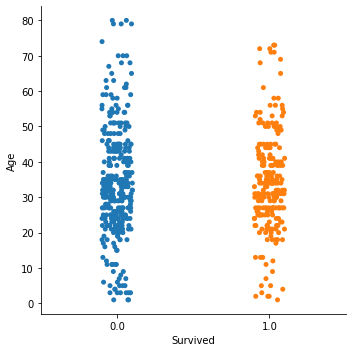

In [35]:
### Plot - 4 is going to be the distribution of survived with respect to continuous variables like Age and Number of Children/Spouses
plt.figure(figsize=(8,5))
fig1 = sns.boxplot(x='Survived',y='Age',data=train_data_final)
fig1.set_title('Box Plot of Age vs Survived')
plt.figure(figsize=(8,5))
fig2 = sns.boxplot(x='Members',y='Age',hue='Survived',data=train_data_final)
fig2.set_title('Scatter plot of Age vs SibSp')
plt.figure(figsize=(8,5))
fig3 = sns.boxplot(x='Pclass',y='Age',hue='Survived',data=train_data_final)
fig3.set_title('Scatter plot of Age vs Passenger Class')
plt.figure(figsize=(8,5))
fig4 = sns.catplot(x='Survived',y='Age',data=train_data_final)
plt.figure(figsize=(8,5))
fig5 = sns.catplot(x='Survived',y='Fare',data=train_data_final)

# Section - 4: Model Building

The general procedure adopted is to first search for hyperparameters using a Random Search method and then fine tune the hyperparamters using a Grid Search

## Model - 1: Logistic Regression

In [15]:
### We will do a 10 fold cross validation repeated over 5 random seeds. We will then average the results for these 5 random seeds and use the average to compare different models
X = new_train_data
Y = y_train.values.ravel()

logisticRegressionModel = LogisticRegression()
logisticRegressionModel.fit(X,Y)
cv_results_lr = cross_val_score(logisticRegressionModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Validation Accuracy:",mean(cv_results_lr)*100,"+-",stdev(cv_results_lr)*100)

### Predicting on test data
y_pred = logisticRegressionModel.predict(test_data)
print("Test Data Accuracy: ", accuracy_score(y_test,y_pred)*100)

Mean Validation Accuracy: 80.02934272300469 +- 1.9530589318360465
Test Data Accuracy:  79.21348314606742


## Model - 2: Random Forests

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

randomForestModel = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = randomForestModel, scoring = 'accuracy', 
                               param_distributions = random_grid, n_iter = 100, 
                               cv = 10,random_state = 123)
rf_random.fit(X, Y)
print(rf_random.best_params_)

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 5}


In [39]:
from sklearn.model_selection import GridSearchCV
### We can now try to do a grid search to fine tune the parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

randomForestModel = RandomForestClassifier()
rf_random = GridSearchCV(estimator = randomForestModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
rf_random.fit(X, Y)
print(rf_random.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 250}


In [16]:
randomForestModel = RandomForestClassifier(n_estimators=250,max_depth=10,max_features='sqrt')
randomForestModel.fit(X,Y)
cv_results_rf = cross_val_score(randomForestModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_rf)*100,"+-",stdev(cv_results_rf)*100)

### Predicting on test datammm
y_pred = randomForestModel.predict(test_data)
print(accuracy_score(y_test,y_pred)*100)

Mean Accuracy: 81.85054773082942 +- 3.310538892898498
81.46067415730337


## Model - 3: Gradient Boosting Machines (GBM)

In [41]:
gradientBoostingModel = XGBClassifier(objective='binary:logistic')
# Number of trees for Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

gb_random = RandomizedSearchCV(estimator = gradientBoostingModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_jobs=4, n_iter = 50,
                         cv = 10, random_state = 123)
gb_random.fit(X, Y)
print(gb_random.best_params_)

{'n_estimators': 200, 'max_depth': 16}


In [42]:
### We can now try to do a grid search to fine tune the parameters
from sklearn.model_selection import GridSearchCV
# Number of trees for Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 180, stop = 220, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(15, 20, num = 5)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

gradientBoostingModel = XGBClassifier(objective='binary:logistic')
gb_random = GridSearchCV(estimator = gradientBoostingModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
gb_random.fit(X, Y)
print(gb_random.best_params_)

{'max_depth': 20, 'n_estimators': 180}


In [17]:
gradientBoostingModel = XGBClassifier(objective='binary:logistic',n_estimators = 180,max_depth = 20)
gradientBoostingModel.fit(X,Y)
cv_results_gbm = cross_val_score(gradientBoostingModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_gbm)*100,"+-",stdev(cv_results_gbm)*100)

### Predicting on test data
y_pred = gradientBoostingModel.predict(test_data)
print(accuracy_score(y_test,y_pred)*100)

Mean Accuracy: 80.02738654147105 +- 4.688065671730456
79.7752808988764


## Model - 4: Support Vector Machines (SVM)

In [44]:
from sklearn.model_selection import RandomizedSearchCV
### Regularization Parameter for SVM
C = [0.1,0.5,0.75,1.0,1.25,1.5,2.0]
### Type of Kernel to be used for SVM
kernel = ['linear','poly','rbf','sigmoid']
gamma = ['auto','scale']

svmModel = SVC()
random_grid = {'C': C,
               'kernel': kernel,
               'gamma':gamma}
svm_random = RandomizedSearchCV(estimator = svmModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_iter = 50,
                         cv = 10, random_state = 123)
svm_random.fit(X,Y)
print(svm_random.best_params_)

{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.5}


In [46]:
### Regularization Parameter for SVM
C = [float(x) for x in np.linspace(start = 0.1,stop = 1.0,num = 100)]
### Type of Kernel to be used for SVM
kernel = ['linear','poly','rbf','sigmoid']
gamma = ['auto','scale']

svmModel = SVC()
random_grid = {'C': C,
               'kernel': kernel,
               'gamma':gamma}
svm_random = GridSearchCV(estimator = svmModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
svm_random.fit(X,Y)
print(svm_random.best_params_)

{'C': 0.4545454545454546, 'gamma': 'scale', 'kernel': 'rbf'}


In [18]:
svmModel = SVC(C = 0.4546, gamma = 'scale',kernel = 'rbf')
svmModel.fit(X,Y)
cv_results_svm = cross_val_score(svmModel,X,Y,cv=KFold(n_splits=10,shuffle=True),
                                 scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_svm)*100,"+-",stdev(cv_results_svm)*100)

### Predicting on test data
y_pred = svmModel.predict(test_data)
print(accuracy_score(y_test,y_pred)*100)

Mean Accuracy: 80.16040688575899 +- 6.122329446493086
79.7752808988764


## Model - 5: K-Nearest Neighbours (KNN)

In [48]:
### Number of nearest neighbours parameter for KNN
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 50, num = 50)]
### Weight of neighbours
weights = ['uniform','distance']
leaf_size = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
knnModel = KNeighborsClassifier()
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'leaf_size': leaf_size}
knn_random = RandomizedSearchCV(estimator = knnModel, scoring = 'accuracy', 
                         param_distributions = random_grid, n_iter = 500,
                         cv = 10, random_state = 123)
knn_random.fit(X,Y)
print(knn_random.best_params_)

{'weights': 'uniform', 'n_neighbors': 43, 'leaf_size': 8}


In [49]:
n_neighbors = [int(x) for x in np.linspace(start = 30, stop = 60, num = 30)]
### Weight of neighbours
weights = ['uniform','distance']
leaf_size = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
knnModel = KNeighborsClassifier()
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'leaf_size': leaf_size}
knn_random = GridSearchCV(estimator = knnModel, scoring = 'accuracy', 
                         param_grid = random_grid,
                         cv = 10)
knn_random.fit(X,Y)
print(knn_random.best_params_)

{'leaf_size': 1, 'n_neighbors': 43, 'weights': 'uniform'}


In [19]:
knnModel = KNeighborsClassifier(n_neighbors = 43, leaf_size = 1, weights = 'uniform')
knnModel.fit(X,Y)
cv_results_knn = cross_val_score(knnModel,X,Y,cv=KFold(n_splits=10,shuffle=True),scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_knn)*100,"+-",stdev(cv_results_knn)*100)

### Predicting on test data
y_pred = knnModel.predict(test_data)
print(accuracy_score(y_test,y_pred)*100)

Mean Accuracy: 79.8943661971831 +- 4.461483598666032
80.89887640449437


## Model - 7: Feed Forward Neural Networks

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape = (9,)))
model.add(Dense(128,activation = 'relu',kernel_regularizer = l2(0.01)))
model.add(Dense(64,activation = 'relu',kernel_regularizer = l2(0.01)))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()
model.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
model.fit(X,Y,epochs = 500,verbose = 0)

W1103 23:12:37.683355 44560 deprecation.py:323] From C:\Users\Anirudh Shankar\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________


In [24]:
### Predicting on test data
y_pred = model.predict(test_data)
y_pred[y_pred>=0.5] = 1.0
y_pred[y_pred<0.5] = 0.0
print(accuracy_score(y_test,y_pred)*100)

82.02247191011236


## Section - 5: Ensemble Modelling by Stacking Classifiers

In [55]:
### Stacking by majority voting
majorityVotingClassifier = VotingClassifier(estimators=[('lr', logisticRegressionModel), 
                                                        ('rf', randomForestModel), 
                                                        ('xgb',gradientBoostingModel),
                                                        ('svm',svmModel),
                                                        ('knn',knnModel)], voting='hard')
majorityVotingClassifier.fit(X,Y)
cv_results_majorityVotingClassifier = cross_val_score(majorityVotingClassifier,
                                                      X,Y,cv=KFold(n_splits=10,shuffle=True),
                                                      scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_majorityVotingClassifier)*100,"+-",
      stdev(cv_results_majorityVotingClassifier)*100)

### Predicting on test data
y_pred = majorityVotingClassifier.predict(test_data)
print(accuracy_score(y_test,y_pred)*100)

Mean Accuracy: 81.57472613458529 +- 4.900775492670931
79.7752808988764


In [63]:
### Stacking by using another classifier
estimators=[('lr', logisticRegressionModel), 
            ('rf', randomForestModel), 
            ('xgb',gradientBoostingModel),
            ('svm',svmModel),
            ('knn',knnModel)]

''''Logistic Regression'''
stackedClassifier_lr = StackingClassifier(estimators = estimators, 
                                          final_estimator = LogisticRegression())
stackedClassifier_lr.fit(X,Y)

cv_results_stacking_lr = cross_val_score(stackedClassifier_lr,
                                         X,Y,cv=KFold(n_splits=10,shuffle=True),
                                         scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_stacking_lr)*100,"+-",
      stdev(cv_results_stacking_lr)*100)
y_pred = stackedClassifier_lr.predict(test_data)
print("Logistic Regression Stacking Estimator: ", accuracy_score(y_test,y_pred)*100)


'''Random Forest Classifier'''
stackedClassifier_rf = StackingClassifier(estimators = estimators, 
                                          final_estimator = RandomForestClassifier())
stackedClassifier_rf.fit(X,Y)
cv_results_stacking_rf = cross_val_score(stackedClassifier_rf,
                                        X,Y,cv=KFold(n_splits=10,shuffle=True),
                                        scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_stacking_rf)*100,"+-",stdev(cv_results_stacking_rf)*100)
y_pred = stackedClassifier_rf.predict(test_data)
print("Random Forest Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)


'''Gradient Boosting Classifier'''
stackedClassifier_gbm = StackingClassifier(estimators = estimators, 
                                       final_estimator = XGBClassifier())
stackedClassifier_gbm.fit(X,Y)
cv_results_stacking_gbm = cross_val_score(stackedClassifier_gbm,
                                          X,Y,cv=KFold(n_splits=10,shuffle=True),
                                          scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_stacking_gbm)*100,"+-",stdev(cv_results_stacking_gbm)*100)
y_pred = stackedClassifier_gbm.predict(test_data)
print("Gradient Boosting Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)


'''K-Nearest Neighbours Classifier'''
stackedClassifier_knn = StackingClassifier(estimators = estimators, 
                                       final_estimator = KNeighborsClassifier())
stackedClassifier_knn.fit(X,Y)
cv_results_stacking_knn = cross_val_score(stackedClassifier_knn,
                                          X,Y,cv=KFold(n_splits=10,shuffle=True),
                                          scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_stacking_gbm)*100,"+-", stdev(cv_results_stacking_gbm)*100)
y_pred = stackedClassifier_knn.predict(test_data)
print("Nearest Neighbours Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)


'''SVM Classifier'''
stackedClassifier_svm = StackingClassifier(estimators = estimators, 
                                       final_estimator = KNeighborsClassifier())
stackedClassifier_svm.fit(X,Y)
cv_results_stacking_svm = cross_val_score(stackedClassifier_svm,
                                          X,Y,cv=KFold(n_splits=10,shuffle=True),
                                          scoring='accuracy')
print("Mean Accuracy:",mean(cv_results_stacking_svm)*100,"+-", stdev(cv_results_stacking_svm)*100)
y_pred = stackedClassifier_svm.predict(test_data)
print("SVM Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)

Mean Accuracy: 81.71165884194053 +- 3.594911374156435
Logistic Regression Stacking Estimator:  81.46067415730337
Mean Accuracy: 81.57668231611893 +- 4.418736538747491
Random Forest Stacking Estimator:  80.89887640449437
Mean Accuracy: 78.62284820031299 +- 5.2129356736705805
Gradient Boosting Stacking Estimator:  77.52808988764045
Mean Accuracy: 78.62284820031299 +- 5.2129356736705805
Nearest Neighbours Stacking Estimator:  81.46067415730337
Mean Accuracy: 80.160406885759 +- 4.969794588434094
SVM Stacking Estimator:  82.58426966292134


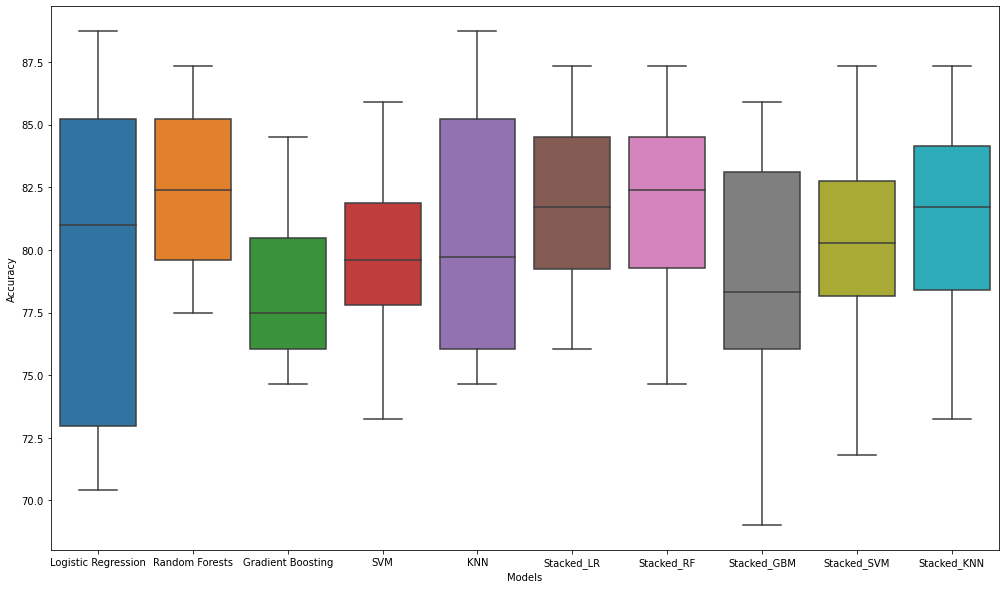

In [64]:
### Plots to compare our different models
data = {'Logistic Regression':cv_results_lr*100,
       'Random Forests':cv_results_rf*100,
       'Gradient Boosting':cv_results_gbm*100,
       'SVM':cv_results_svm*100,
       'KNN':cv_results_knn*100,
       'Stacked_LR':cv_results_stacking_lr*100,
       'Stacked_RF':cv_results_stacking_rf*100,
       'Stacked_GBM':cv_results_stacking_gbm*100,
       'Stacked_SVM':cv_results_stacking_svm*100,
       'Stacked_KNN':cv_results_stacking_knn*100}
model_results = pd.DataFrame(data = data)
model_results = model_results.stack().reset_index()
model_results = model_results.rename(columns = {'level_1':'Models',0:'Accuracy'})
plt.figure(figsize=(17,10))
fig1 = sns.boxplot(x='Models',y='Accuracy',data = model_results)

In [65]:
### Predicting on Test Data
y_pred = logisticRegressionModel.predict(test_data)
print("LR Model: ",accuracy_score(y_test,y_pred)*100)

y_pred = randomForestModel.predict(test_data)
print("RF Model: ",accuracy_score(y_test,y_pred)*100)

y_pred = gradientBoostingModel.predict(test_data)
print("GBM Model: ",accuracy_score(y_test,y_pred)*100)

y_pred = svmModel.predict(test_data)
print("SVM Model: ",accuracy_score(y_test,y_pred)*100)

y_pred = knnModel.predict(test_data)
print("KNN Model: ",accuracy_score(y_test,y_pred)*100)

y_pred = stackedClassifier_lr.predict(test_data)
print("LR Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)

y_pred = stackedClassifier_rf.predict(test_data)
print("RF Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)

y_pred = stackedClassifier_gbm.predict(test_data)
print("GBM Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)

y_pred = stackedClassifier_knn.predict(test_data)
print("KNN Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)

y_pred = stackedClassifier_svm.predict(test_data)
print("SVM Stacking Estimator: ",accuracy_score(y_test,y_pred)*100)

LR Model:  79.21348314606742
RF Model:  80.33707865168539
GBM Model:  79.7752808988764
SVM Model:  79.7752808988764
KNN Model:  80.89887640449437
LR Stacking Estimator:  81.46067415730337
RF Stacking Estimator:  80.89887640449437
GBM Stacking Estimator:  77.52808988764045
KNN Stacking Estimator:  81.46067415730337
SVM Stacking Estimator:  82.58426966292134


## Section - 6: Prediction on Actual Test Data

In [66]:
### Making Actual Predictions
actual_test_data = actual_test_data.drop(['Cabin'],axis=1)
actual_test_data = actual_test_data.drop(['Sex'],axis=1)
actual_test_data = actual_test_data.drop(['Embarked'],axis=1)

actual_test_data = pd.DataFrame(scaler.fit_transform(actual_test_data), 
                                columns = actual_test_data.columns)

imputer = KNNImputer(n_neighbors=10)
actual_test_data = pd.DataFrame(imputer.fit_transform(actual_test_data),
                                columns = actual_test_data.columns)

In [67]:
test_predictions = stackedClassifier_svm.predict(actual_test_data)
test_predictions = test_predictions.astype(int)
passenger_id = np.arange(892,1310)
test_results = pd.DataFrame(data = {'PassengerId':passenger_id,'Survived':test_predictions})
test_results.to_csv('submission.csv',index = False)
print('Saved file: ' + 'submission.csv')

Saved file: submission.csv


In [28]:
### Building a pickle file of our final machine learning model
### Our final model is the stacked SVM classifier
estimators=[('lr', logisticRegressionModel), 
            ('rf', randomForestModel), 
            ('xgb',gradientBoostingModel),
            ('svm',svmModel),
            ('knn',knnModel)]
stackedClassifier_svm = StackingClassifier(estimators = estimators, 
                                       final_estimator = KNeighborsClassifier())
stackedClassifier_svm.fit(X,Y)
pickle.dump(stackedClassifier_svm,open('model.pkl','wb'))

In [39]:
print(X)
model = pickle.load(open('model.pkl','rb'))
print(model.predict(np.array([0.5, 0.478, 0.1, 0.567, 1.0, 0.0, 1.0, 0.0, 0.0]).reshape(1,-1)))

     Pclass       Age  Members      Fare  female  male    C    Q    S
0       0.0  0.487107      0.1  0.101497     1.0   0.0  0.0  0.0  1.0
1       0.5  0.263247      0.0  0.050749     1.0   0.0  0.0  0.0  1.0
2       0.5  0.249079      0.2  0.025374     1.0   0.0  0.0  0.0  1.0
3       0.0  0.546614      0.2  0.155466     1.0   0.0  0.0  0.0  1.0
4       1.0  0.348257      0.0  0.000000     0.0   1.0  0.0  0.0  1.0
5       0.0  0.674129      0.1  0.077294     1.0   0.0  1.0  0.0  0.0
6       0.5  0.178237      0.1  0.038061     1.0   0.0  0.0  0.0  1.0
7       1.0  0.334089      0.2  0.032596     1.0   0.0  0.0  0.0  1.0
8       0.5  0.631624      0.0  0.026350     1.0   0.0  0.0  0.0  1.0
9       1.0  0.390762      0.2  0.028107     1.0   0.0  0.0  0.0  1.0
10      0.0  0.617455      0.1  0.113168     1.0   0.0  1.0  0.0  0.0
11      1.0  0.263247      0.0  0.015924     0.0   1.0  0.0  0.0  1.0
12      0.0  0.532445      0.0  0.444099     1.0   0.0  1.0  0.0  0.0
13      1.0  0.37659